# Задача 1

In [153]:
import numpy as np
import scipy.linalg as lg
from scipy.sparse import diags

In [154]:
def jakobi(A, b, eps=1e-8, count=False):
    new_b = np.reshape(b, (-1,1))
    L = np.tril(A, k=-1)
    Dinv = np.diag(np.diag(A)**(-1)) # we need to compute inverse matrix only
    U = np.triu(A, k=1)
    
    # some cache
    DinvLU = Dinv @ (-L - U)
    Dinvb = Dinv @ new_b
    
    q = np.linalg.norm(Dinv, ord=2)
    
    x = np.zeros((A.shape[0], 1))
    xn = DinvLU @ x + Dinvb
    k = 1
    while(np.linalg.norm((xn - x), ord=2) > (1-q)*eps):
        x = xn
        k += 1
        xn = DinvLU @ x + Dinvb
    if count:
        return (xn, k)
    else:
        return xn

In [155]:
def make_matricies(n, a):
    diagonals = [2 * np.ones((n)), 
                 (-1-a) * np.ones((n-1)),
                 (-1+a) * np.ones((n-1))]
    A = diags(diagonals, [0, 1, -1]).toarray()
    b = np.zeros((n, 1))
    b[0] = 1 - a
    b[n-1] = 1 + a
    return (A, b)    

Точное решение -- единичный вектор

In [53]:
N = 20
max_a = 1
a_pts = 20
eps = 1e-8

def mean_steps_j(N, a, runs=10):
    kk1 = []
    for _ in range(runs):
        A, b = make_matricies(N, a)
        mine1, k1 = jakobi(A, b, eps=eps, count=True)
        kk1.append(k1)
    return np.mean(kk1)
        
        
nn = np.arange(2, N)
aa = np.linspace(-max_a, max_a, a_pts)
Nn, Aa = np.meshgrid(nn, aa)
js = np.zeros(Nn.shape)
for n in range(nn.shape[0]):
    for a in range(aa.shape[0]):
        js[a, n] = mean_steps_j(nn[n], aa[a], runs=1)

На графике ниже построено среднее число итераций метода для достижения точности в eps

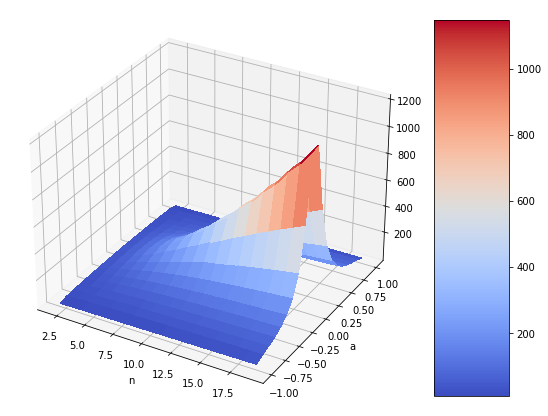

In [54]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(9, 16))

# ax.scatter(Nn, Aa, js, label='parametric curve')
surf = ax.plot_surface(Nn, Aa, js, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_xlabel("n")
ax.set_ylabel("a")

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

# Задача 2

In [9]:
def seidel(A, b, eps=1e-8, count=False):
    nb = np.reshape(b, (-1,1))
    LD = np.tril(A, k=0)
    U = np.triu(A, k=1)
    LDinv = lg.solve_triangular(LD, np.identity(LD.shape[0]), lower=True)
    LDinvU = -LDinv @ U
    LDb = LDinv @ nb
    q = np.linalg.norm(LDinvU, ord=2)
    x = np.zeros((A.shape[0], 1))
    xn = LDinvU @ x + LDb
    k = 1
    while(np.linalg.norm((xn - x), ord=2) > (1-q)*eps):
        x = xn
        k += 1
        xn = LDinvU @ x + LDb
    if count:
        return (xn, k)
    else:
        return xn

In [55]:
N = 20
max_a = 1
a_pts = 20
eps = 1e-8

def mean_steps_s(N, a, runs=10):
    kk1 = []
    for _ in range(runs):
        A, b = make_matricies(N, a)
        mine1, k1 = seidel(A, b, eps=eps, count=True)
        kk1.append(k1)
    return np.mean(kk1)
        
        
nn = np.arange(2, N)
aa = np.linspace(-max_a, max_a, a_pts)
Nn, Aa = np.meshgrid(nn, aa)
ss = np.zeros(Nn.shape)
for n in range(nn.shape[0]):
    for a in range(aa.shape[0]):
        ss[a, n] = mean_steps_s(nn[n], aa[a], runs=1)

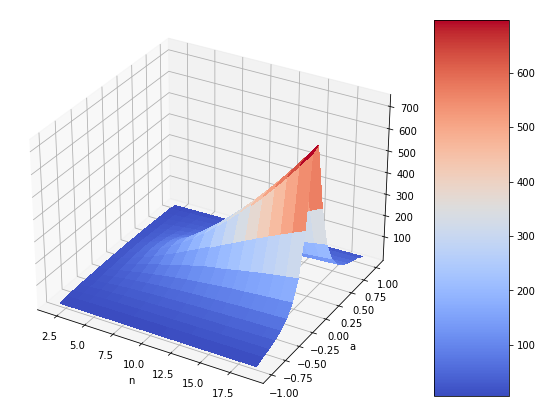

In [56]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(9, 16))

# ax.scatter(Nn, Aa, ss, label='parametric curve')
surf = ax.plot_surface(Nn, Aa, ss, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_xlabel("n")
ax.set_ylabel("a")

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

Как видно из сравнения графиков, метод Зейделя сходится примерно в 2 раза быстрее

# Задача 4

In [19]:
import numpy as np
import scipy.linalg as lg
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

In [83]:
def solve_relax(A, b, t, eps=1e-8, count=False):
    np.reshape(b, (-1, 1))
    LD = np.tril(A, k=0)
    U = np.triu(A, k=1)
    
    # x_k+1 = t(L+D)^-1(b-Ax_k) + x_k = tLDb + EbLDA @ x_k
    LDinv = lg.solve_triangular(LD, np.identity(LD.shape[0]), lower=True)
    tLDb = t * LDinv @ b
    EbLDA = np.eye(A.shape[0]) - t * LDinv @ A
    
    q = np.linalg.norm(EbLDA, ord=2)
    x = np.zeros((A.shape[0], 1))
    xn = tLDb + EbLDA @ x
    k = 1
    while(np.linalg.norm((xn - x), ord=2) > (1-q)*eps):
        x = xn
        k += 1
        xn = tLDb + EbLDA @ x
        if k > 4e4:
            print("Not converges or converges slow, t={}, n={}, a={}".format(t, A.shape[0], A[1,0]+1))
            return (x, k)
    if count:
        return (xn, k)
    else:
        return xn

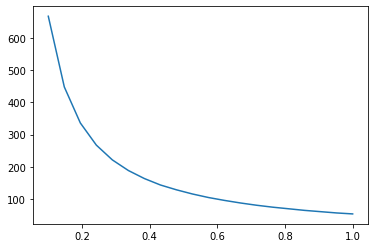

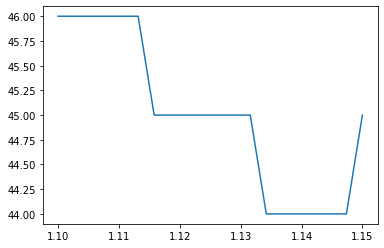

In [104]:
N = 20
max_a = 1
a_pts = 20
eps = 1e-8
t_min = 0.1
t_max = 1 # with some
t_pts = 20

n0 = 15
a0 = 0.7


ts = np.linspace(t_min, t_max, t_pts)

def mean_steps_r(N, a, t, runs=1):
    kk1 = []
    A, b = make_matricies(N, a)
    for _ in range(runs):
        mine1, k1 = solve_relax(A, b, t, eps=eps, count=True)
        if(np.linalg.norm(A @ mine1 - b, ord=2) > eps):
            print("Error occured t={}".format(t))
        kk1.append(k1)
    return np.mean(kk1)

ops = []
for t in ts:
    ops.append(mean_steps_r(n0, a0, t))

plt.plot(ts, ops)
plt.show()



t_min = 1.1
t_max = 1.15 # with some
t_pts = 20

ts = np.linspace(t_min, t_max, t_pts)

ops = []
for t in ts:
    ops.append(mean_steps_r(n0, a0, t))

plt.plot(ts, ops)
plt.show()

Видна тенденция уменьшения числа итерация для сходимости при увиличении t. Незначительно t может залезать в область > 1, но это зависит от параметров матрицы и эту точку нужно искать.

In [123]:
n0 = np.array([2, 10, 20])
a0 = np.array([-0.8, 0.5, 0.9])

def find_opt_t(N, a):
    ts = np.linspace(0.1, 2, 20)
    ops = []
    t = 0
    stpspr = 10000
    for t in ts:
        stps = mean_steps_r(N, a, t)
        if stps/stpspr > 1.1:
            break       
    ts = np.linspace(t-0.11, t-0.01, 20)
    stpspr = 10000
    for t in ts:
        stps = mean_steps_r(N, a, t)
        if stps/stpspr > 1.1:
            break   
        ops.append(stps)
    mstp = np.min(ops)
    return np.max(ts[np.where(mstp == ops)])

topts = np.zeros((n0.shape[0], a0.shape[0]))
for i in range(n0.shape[0]):
    for j in range(a0.shape[0]):      
        topts[i, j] = find_opt_t(n0[i], a0[j])    
print(topts)

Error occured t=0.1
Error occured t=0.2
Not converges or converges slow, t=2.0, n=2, a=-0.8
Error occured t=2.0
Not converges or converges slow, t=1.953157894736842, n=2, a=-0.8
Not converges or converges slow, t=1.3, n=2, a=0.5
Not converges or converges slow, t=1.2794736842105263, n=2, a=0.5
Not converges or converges slow, t=1.0999999999999999, n=2, a=0.9
Not converges or converges slow, t=1.053157894736842, n=2, a=0.9
Not converges or converges slow, t=2.0, n=10, a=-0.8
Error occured t=2.0
Not converges or converges slow, t=1.9057894736842105, n=10, a=-0.8
Not converges or converges slow, t=1.3, n=10, a=0.5
Not converges or converges slow, t=1.253157894736842, n=10, a=0.5
Not converges or converges slow, t=1.0999999999999999, n=10, a=0.9
Not converges or converges slow, t=1.053157894736842, n=10, a=0.9
Not converges or converges slow, t=2.0, n=20, a=-0.8
Error occured t=2.0
Not converges or converges slow, t=1.9057894736842105, n=20, a=-0.8
Not converges or converges slow, t=1.3, n

Видно, что для больших матриц t стоит брать ближе к 1. Будем стараться пользоваться максимальным.

In [124]:
N = 20
max_a = 1
a_pts = 5

t = 1 
nn = np.arange(2, N, 3)
aa = np.linspace(-max_a, max_a, a_pts)
Nn, Aa = np.meshgrid(nn, aa)
ss = np.zeros(Nn.shape)
for n in range(nn.shape[0]):
    for a in range(aa.shape[0]):
        t = find_opt_t(nn[n], aa[a])
        ss[a, n] = mean_steps_r(nn[n], aa[a], t, runs=1)

Error occured t=0.1
Not converges or converges slow, t=2.0, n=2, a=-1.0
Error occured t=2.0
Error occured t=0.1
Not converges or converges slow, t=1.9, n=2, a=-0.5
Not converges or converges slow, t=1.847894736842105, n=2, a=-0.5
Not converges or converges slow, t=1.5999999999999999, n=2, a=0.0
Not converges or converges slow, t=1.5899999999999999, n=2, a=0.0
Not converges or converges slow, t=1.3, n=2, a=0.5
Not converges or converges slow, t=1.2794736842105263, n=2, a=0.5
Not converges or converges slow, t=1.0999999999999999, n=2, a=1.0
Not converges or converges slow, t=1.0005263157894735, n=2, a=1.0
Not converges or converges slow, t=2.0, n=5, a=-1.0
Error occured t=2.0
Not converges or converges slow, t=1.8, n=5, a=-0.5
Not converges or converges slow, t=1.7689473684210526, n=5, a=-0.5
Not converges or converges slow, t=1.5999999999999999, n=5, a=0.0
Not converges or converges slow, t=1.521578947368421, n=5, a=0.0
Not converges or converges slow, t=1.3, n=5, a=0.5
Not converges or

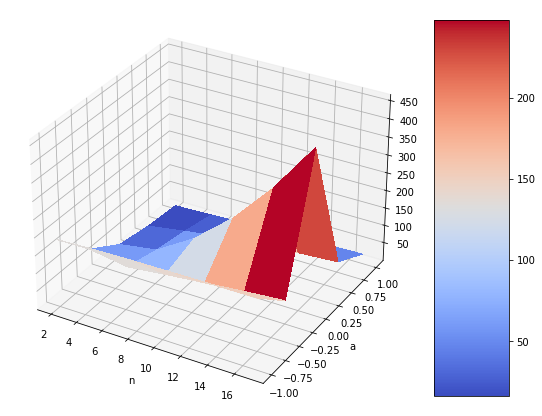

In [125]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(9, 16))

# ax.scatter(Nn, Aa, ss, label='parametric curve')
surf = ax.plot_surface(Nn, Aa, ss, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_xlabel("n")
ax.set_ylabel("a")

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

Выбором оптимальных t удалось добится быстрейшей в 2-3 раза сходимости, но какой ценой! Заметен также неясный подъем в области отрицательных $\alpha$.

# Задача 5

In [126]:
def solve_urelax(A, b, t, eps=1e-8, count=False):
    np.reshape(b, (-1, 1))
    LtD = t * np.tril(A, k=-1) + np.diag(np.diag(A))
    U = np.triu(A, k=1)
    
    # x_k+1 = t(L+D)^-1(b-Ax_k) + x_k = tLDb + EbLDA @ x_k
    LtDinv = lg.solve_triangular(LtD, np.identity(LtD.shape[0]), lower=True)
    tLtDb = t * LtDinv @ b
    EbLtDA = np.eye(A.shape[0]) - t * LtDinv @ A
    
    q = np.linalg.norm(EbLtDA, ord=2)
    x = np.zeros((A.shape[0], 1))
    xn = tLtDb + EbLtDA @ x
    k = 1
    while(np.linalg.norm((xn - x), ord=2) > (1-q)*eps):
        x = xn
        k += 1
        xn = tLtDb + EbLtDA @ x
        if k > 4e4:
            print("Not converges or converges slow, t={}, n={}, a={}".format(t, A.shape[0], A[1,0]+1))
            return (x, k)
    if count:
        return (xn, k)
    else:
        return xn

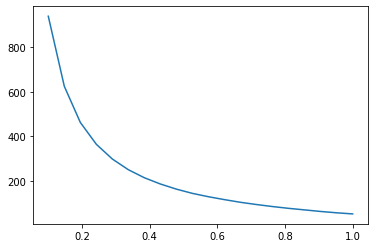

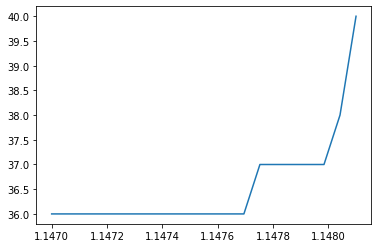

In [133]:
N = 20
max_a = 1
a_pts = 20
eps = 1e-8
t_min = 0.1
t_max = 1 # with some
t_pts = 20

n0 = 15
a0 = 0.7


ts = np.linspace(t_min, t_max, t_pts)

def mean_steps_ur(N, a, t, runs=1):
    kk1 = []
    A, b = make_matricies(N, a)
    for _ in range(runs):
        mine1, k1 = solve_urelax(A, b, t, eps=eps, count=True)
        if(np.linalg.norm(A @ mine1 - b, ord=2) > eps):
            print("Error occured t={}".format(t))
        kk1.append(k1)
    return np.mean(kk1)

ops = []
for t in ts:
    ops.append(mean_steps_ur(n0, a0, t))

plt.plot(ts, ops)
plt.show()



t_min = 1.147
t_max = 1.1481 # with some
t_pts = 20

ts = np.linspace(t_min, t_max, t_pts)

ops = []
for t in ts:
    ops.append(mean_steps_ur(n0, a0, t))

plt.plot(ts, ops)
plt.show()

In [135]:
n0 = np.array([2, 10, 20])
a0 = np.array([-0.8, 0.5, 0.9])

def find_opt_ur_t(N, a):
    ts = np.linspace(0.1, 2, 20)
    ops = []
    t = 0
    stpspr = 10000
    for t in ts:
        stps = mean_steps_ur(N, a, t)
        if stps/stpspr > 1.1:
            break       
    ts = np.linspace(t-0.11, t-0.01, 20)
    stpspr = 10000
    for t in ts:
        stps = mean_steps_ur(N, a, t)
        if stps/stpspr > 1.1:
            break   
        ops.append(stps)
    mstp = np.min(ops)
    return np.max(ts[np.where(mstp == ops)])

topts = np.zeros((n0.shape[0], a0.shape[0]))
for i in range(n0.shape[0]):
    for j in range(a0.shape[0]):      
        topts[i, j] = find_opt_ur_t(n0[i], a0[j])    
print(topts)

Not converges or converges slow, t=1.5999999999999999, n=2, a=-0.8
Not converges or converges slow, t=1.5689473684210524, n=2, a=-0.8
Not converges or converges slow, t=1.3, n=2, a=0.5
Not converges or converges slow, t=1.2794736842105263, n=2, a=0.5
Not converges or converges slow, t=1.0999999999999999, n=2, a=0.9
Not converges or converges slow, t=1.053157894736842, n=2, a=0.9
Not converges or converges slow, t=1.2, n=10, a=-0.8
Not converges or converges slow, t=1.3, n=10, a=0.5
Not converges or converges slow, t=1.2426315789473685, n=10, a=0.5
Not converges or converges slow, t=1.0999999999999999, n=10, a=0.9
Not converges or converges slow, t=1.053157894736842, n=10, a=0.9
Not converges or converges slow, t=1.2, n=20, a=-0.8
Not converges or converges slow, t=1.147894736842105, n=20, a=-0.8
Not converges or converges slow, t=1.3, n=20, a=0.5
Not converges or converges slow, t=1.2373684210526317, n=20, a=0.5
Not converges or converges slow, t=1.0999999999999999, n=20, a=0.9
Not con

Здесь оптимальные параметры t уже меньше

In [136]:
N = 20
max_a = 1
a_pts = 5

t = 1 
nn = np.arange(2, N, 3)
aa = np.linspace(-max_a, max_a, a_pts)
Nn, Aa = np.meshgrid(nn, aa)
ss = np.zeros(Nn.shape)
for n in range(nn.shape[0]):
    for a in range(aa.shape[0]):
        t = find_opt_ur_t(nn[n], aa[a])
        ss[a, n] = mean_steps_r(nn[n], aa[a], t, runs=1)

Not converges or converges slow, t=1.5, n=2, a=-1.0
Not converges or converges slow, t=1.7, n=2, a=-0.5
Not converges or converges slow, t=1.6268421052631579, n=2, a=-0.5
Not converges or converges slow, t=1.5999999999999999, n=2, a=0.0
Not converges or converges slow, t=1.5531578947368418, n=2, a=0.0
Not converges or converges slow, t=1.3, n=2, a=0.5
Not converges or converges slow, t=1.2794736842105263, n=2, a=0.5
Not converges or converges slow, t=1.0999999999999999, n=2, a=1.0
Not converges or converges slow, t=1.0005263157894735, n=2, a=1.0
Not converges or converges slow, t=1.2, n=5, a=-1.0
Not converges or converges slow, t=1.4, n=5, a=-0.5
Not converges or converges slow, t=1.5, n=5, a=0.0
Not converges or converges slow, t=1.421578947368421, n=5, a=0.0
Not converges or converges slow, t=1.3, n=5, a=0.5
Not converges or converges slow, t=1.253157894736842, n=5, a=0.5
Not converges or converges slow, t=1.0999999999999999, n=5, a=1.0
Not converges or converges slow, t=1.000526315

C:\Users\dedko\AppData\Local\Temp/ipykernel_400/4011237550.py:18: RuntimeWarning: overflow encountered in matmul
  xn = tLtDb + EbLtDA @ x
C:\Users\dedko\AppData\Local\Temp/ipykernel_400/1013427256.py:20: RuntimeWarning: overflow encountered in matmul
  if(np.linalg.norm(A @ mine1 - b, ord=2) > eps):
C:\Users\dedko\AppData\Local\Temp/ipykernel_400/1013427256.py:20: RuntimeWarning: invalid value encountered in matmul
  if(np.linalg.norm(A @ mine1 - b, ord=2) > eps):


LinAlgError: SVD did not converge

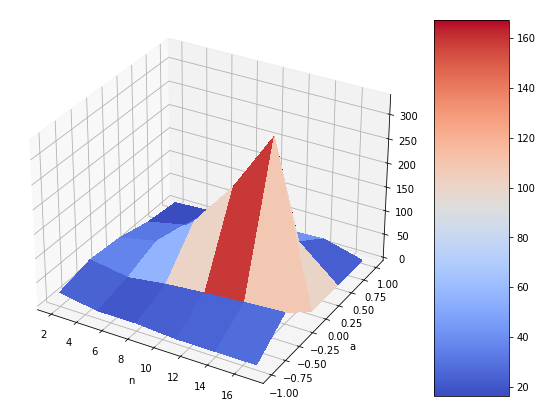

In [137]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(9, 16))

# ax.scatter(Nn, Aa, ss, label='parametric curve')
surf = ax.plot_surface(Nn, Aa, ss, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_xlabel("n")
ax.set_ylabel("a")

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

При оптимальном параметре сходимость стала еще лучше!

# Задача 6

Воспользуемся кодом МПИ с 3го ДЗ

In [171]:
# finding parametre for S-I method
def find_tau(A):
    E = np.eye(A.shape[0])
    delta = 1
    t = 0
    dt = 1e-3
    q = np.linalg.norm(E-t*A, ord=2)
    k = 0
    while q > 1-1e-6:
        dq = -np.linalg.norm(E-(t+dt)*A, ord=2) + q
        t += dq * delta
        k += 1
        if(k>100):
            k = 0
            delta *= 0.1
        q = np.linalg.norm(E-t*A, ord=2)
        print(q)
        
    return (t, q)

def simple_iteration(A, b, eps=1e-8, count=False):
    nb = np.reshape(b, (-1,1))
    t, q = find_tau(A)
    M = np.eye(A.shape[0]) - t*A
    tb = t*nb
    x = np.zeros(tb.shape)
    xn = M @ x + tb
    k = 1
    while(np.linalg.norm(xn-x, ord=2) > eps*(1-q)):
        k += 1
        x = xn
        xn= M @ x + tb
    if count:
        return (xn, k)
    else:
        return xn

И видоизменим для ускорения методом Чебышева

In [172]:
def chebishov(A, b, mu=0, eps = 1e-8):
    b.reshape((-1, 1))
    if mu == 0:
        ls = np.abs(np.linalg.eigvals(A))
        print(ls)
        mu = np.max(ls)
        print(mu)
        print('Hi')
    
    t, q = find_tau(A)
    R = np.eye(A.shape[0]) - t*A
    # we will cycle with finding ym=y2
    # pm2 = p_m-2
    pm2 = 1
    pm1 = mu
    ym2 = np.zeros(b.shape)
    ym1 = R @ ym2 + b
    m = 2
    q = 0.5
    print(ym1)
    while (m < 10) or (np.linalg.norm(ym1 - ym2, ord=2) > eps):
        m += 1
        pm = 1 / (2/mu / pm1 - 1 / pm2)
        ym = 2 / mu * pm/pm1 * R @ ym1 - pm/pm2 * ym2 + 2/mu * pm/pm1 * b
        if m % 10 == 0:
            q = np.linalg.norm(ym-ym1, ord=2) / np.linalg.norm(ym1-ym2, ord=2)
            print(m)
            print(q)
        
        pm2 = pm1
        pm1 = pm
        ym2 = ym1
        ym1 = ym
    return ym

In [173]:
A, b = make_matricies(10, 0.5)
print(chebishov(A, b))

[0.33810942 0.54290614 0.86574794 1.28048009 1.75350347 2.24649653
 3.66189058 3.45709386 3.13425206 2.71951991]
3.6618905798056547
Hi
0.9999934395676768
[[0.5]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [1.5]]
10
1.6806074518571474
20
1.1768618557241683
30
0.9403973543502036
40
0.7483533665262118
50
0.5159215247954374
60
0.10422954289177558
70
1.3777253828335092
80
4.677197049641174
90
1.7977132320596338
100
1.2792570470661506
110
1.0156233652708877
120
0.8147190470800515
130
0.6028954519130086
140
0.28765908163505227
150
0.5018346939026166
160
153.8973681027497
170
2.1859124224874495
180
1.413638110122328
190
1.0987771123371792
200
0.8853611958053214
210
0.6841207659967615
220
0.42296726317110256
230
0.09204901375420466
240
3.0989843300971014
250
2.992475329219025
260
1.5944216063371528
270
1.1935793228379385
280
0.9581509634725507
290
0.7593840671280353
300
0.5307508622917668
310
0.15376839705703763
320
1.0567966175156944
330
5.820169272800358
340
1.8618228259914877
35

3640
0.6614524470331438
3650
0.38846331267397266
3660
0.17517022709685476
3670
4.513489439606922
3680
2.6931144649362673
3690
1.5371001062970413
3700
1.1669436476182522
3710
0.9388700525795316
3720
0.7391577391095463
3730
0.5028018936057905
3740
0.0989422584913726
3750
1.3517489996028889
3760
4.543820032921667
3770
1.7752399435487995
3780
1.2741779166959726
3790
1.0148263475472108
3800
0.8124424780868724
3810
0.59802983473991
3820
0.2829360741547752
3830
0.5008310445154387
3840
109.6386012471113
3850
2.1651426863483856
3860
1.40812770214256
3870
1.0976095274609883
3880
0.8842694906476551
3890
0.6814209101092011
3900
0.4193077159252099
3910
0.09434829914625639
3920
3.1160688602447872
3930
2.9631644796162315
3940
1.5877832682102826
3950
1.1918369041200236
3960
0.9573716685443134
3970
0.7577189486280268
3980
0.527985545967544
3990
0.15099014101739022
4000
1.0608016362846293
4010
5.729169213190259
4020
1.8531886809143405
4030
1.304535877423869
4040
1.0346790653780973
4050
0.830381447115170

0.2713969523782765
7100
7.578913874757054
7110
2.472605802171983
7120
1.4888173791961992
7130
1.1420989905165362
7140
0.919847888770725
7150
0.7195146286224642
7160
0.47528874334286086
7170
0.039129807254577265
7180
1.7572893384765018
7190
3.7921418611551334
7200
1.703275820279001
7210
1.244279860734747
7220
0.9946251233973605
7230
0.7936604499261743
7240
0.5746361160457308
7250
0.24088939712874724
7260
0.6567270723297813
7270
13.901740063740395
7280
2.040768708844531
7290
1.3699129356104234
7300
1.0752548305769714
7310
0.8656172622149416
7320
0.6605815298965617
7330
0.38711731066711164
7340
0.1785678598681906
7350
4.5883900096850505
7360
2.683139562153593
7370
1.5350220406841364
7380
1.1659508862960397
7390
0.9381333597432795
7400
0.7383670283125916
7410
0.5016944188501359
7420
0.09673792999678975
7430
1.3647118494957016
7440
4.507196822561211
7450
1.7720927371563187
7460
1.2729510270846447
7470
1.014043458028088
7480
0.8116993579354097
7490
0.597080189419765
7500
0.28132626161515295


10790
2.464956410065077
10800
1.48700775713766
10810
1.141161508762379
10820
0.9191198410680519
10830
0.718737342878344
10840
0.4741793864071157
10850
0.036703526971833884
10860
1.7755366136810578
10870
3.7689433811815944
10880
1.7006148775208634
10890
1.243152546250023
10900
0.9938583711905324
10910
0.7929264925363174
10920
0.5736967292757243
10930
0.23919103730717114
10940
0.6632779879660352
10950
13.473996858636355
10960
2.036293836436568
10970
1.3684753432054853
10980
1.074410241791666
10990
0.8648975195007872
11000
0.6597511346388955
11010
0.38581886246377906
11020
0.18201415259747697
11030
4.666248057843539
11040
2.673611235920794
11050
1.5330516126399951
11060
1.1649746381417776
11070
0.9373988701053055
11080
0.7376042058246558
11090
0.5006362348199577
11100
0.09454101932367039
11110
1.3780631077947627
11120
4.471912757233619
11130
1.769113175432154
11140
1.2717612337774828
11150
1.0132613825597374
11160
0.8109720328412715
11170
0.5961739186236096
11180
0.27975015663191766
11190

15610
0.3842082977556388
15620
0.18635823940475776
15630
4.767033313287478
15640
2.6619461953619736
15650
1.5306330621523137
15660
1.163761926464063
15670
0.9364817253736933
15680
0.7366593691166863
15690
0.4993280798422688
15700
0.09178825424467667
15710
1.3950527924272462
15720
4.4289497407711425
15730
1.7654620062121
15740
1.270289998726558
15750
1.0122847776577562
15760
0.8100678938447611
15770
0.5950545889167668
15780
0.2777867682710309
15790
0.5184961749547594
15800
57.6762887555522
15810
2.1479607962626655
15820
1.403078456589654
15830
1.0947746751357843
15840
0.8819237960499261
15850
0.6787683072870282
15860
0.41529191376767816
15870
0.10421739893870802
15880
3.2539408970266113
15890
2.9232047658359837
15900
1.580707309722793
15910
1.1885126165607751
15920
0.9549564431921326
15930
0.7552647902420664
15940
0.5246653206821184
15950
0.1444635090893965
15960
1.0939378619534057
15970
5.533119114363807
15980
1.8421547102304112
15990
1.3004181564986215
16000
1.0320791948057748
16010
0

19510
1.0939079773254514
19520
0.881205747685878
19530
0.6779705913499049
19540
0.4140779364734508
19550
0.10729444247644601
19560
3.2986071799844137
19570
2.9114021306310987
19580
1.5786087053849636
19590
1.1875042431478922
19600
0.9542144879706781
19610
0.7545220342065572
19620
0.523666920083431
19630
0.14245241115711152
19640
1.1044545459975914
19650
5.47630698449834
19660
1.838889198764508
19670
1.2991802062579394
19680
1.031281291316591
19690
0.8273067103472288
19700
0.6159725630906951
19710
0.3141190152390301
19720
0.39508130831907823
19730
21.55091745912103
19740
2.280566869099922
19750
1.440531917858451
19760
1.11598497147197
19770
0.8991978823740582
19780
0.6975877510375363
19790
0.4435175503493432
19800
0.03438994133111279
19810
2.404779122565585
19820
3.2498252224478414
19830
1.633442067383883
19840
1.2133162508396578
19850
0.9729297904383771
19860
0.7729068424106611
19870
0.5479938834633815
19880
0.19068234143472462
19890
0.8685572834068653
19900
7.483384950355541
19910
1.9

0.9346492990965077
24880
0.7347773244472167
24890
0.49672141362341926
24900
0.08624796849406753
24910
1.429875286164722
24920
4.34617964150112
24930
1.7582837249379424
24940
1.2673736375660352
24950
1.0103346667135857
24960
0.8082642599054386
24970
0.5928267410133897
24980
0.27385267664296814
24990
0.532498221955263
25000
42.4096012703422
25010
2.1353577644885826
25020
1.399327540202078
25030
1.0926105394306391
25040
0.8801293851280403
25050
0.6767759446254865
25060
0.41225641828728493
25070
0.11194016830438047
25080
3.3674868206405404
25090
2.893968711935589
25100
1.5754862083413017
25110
1.185996870245376
25120
0.9531023076462523
25130
0.753409366185868
25140
0.5221706988187909
25150
0.1394240772829624
25160
1.1204483550121023
25170
5.393667906927262
25180
1.8340384182427047
25190
1.2973327338980438
25200
1.0300858994860498
25210
0.8262301255800744
25220
0.6146787523581939
25230
0.3119201089055174
25240
0.4021974858934922
25250
23.682809858016054
25260
2.271596265184167
25270
1.43811

28270
2.4300907957202633
28280
1.4786728351446878
28290
1.1367516419867243
28300
0.9156702607446092
28310
0.7150982161578124
28320
0.46898222105754
28330
0.025052064290753046
28340
1.8663509697065788
28350
3.6644175575943607
28360
1.68841419171946
28370
1.2378895337602094
28380
0.9902237053625689
28390
0.7894730386928782
28400
0.5693089744544377
28410
0.2311196983090697
28420
0.6953385224308327
28430
11.775930857407166
28440
2.0158296196436742
28450
1.3618146406093925
28460
1.0704190547842054
28470
0.8614947962445815
28480
0.6558694888968113
28490
0.3797014104168078
28500
0.19869593490305593
28510
5.0702572469004465
28520
2.6302030338851163
28530
1.523977742733341
28540
1.1603889130453744
28550
0.9339170069617321
28560
0.7340256352832534
28570
0.49567884789680833
28580
0.084017541635754
28590
1.4441098765232037
28600
4.314151065748115
28610
1.7554458885188053
28620
1.2662136713561296
28630
1.0095557291620827
28640
0.8075436562707856
28650
0.5919366288701561
28660
0.27227346680061676
28

32280
4.282702758389054
32290
1.7526236987244637
32300
1.265056492534019
32310
1.0087774036383246
32320
0.8068234800096333
32330
0.5910465701085437
32340
0.27069045498715055
32350
0.543895314908609
32360
35.057562766207646
32370
2.125459407472591
32380
1.3963549597512517
32390
1.0908845968874779
32400
0.8786955793603528
32410
0.675184824444662
32420
0.4098234580753332
32430
0.1181904473987612
32440
3.4629687271690632
32450
2.8711856393073165
32460
1.5713597023985635
32470
1.1839943718319612
32480
0.9516209518915791
32490
0.7519275350857135
32500
0.5201753154957484
32510
0.1353626020352916
32520
1.1421774263366362
32530
5.287984249045849
32540
1.8276433428146568
32550
1.294882572616017
32560
1.0284945482029861
32570
0.8247961503398614
32580
0.6129549243983372
32590
0.3089784531679086
32600
0.41180084723481114
32610
27.2484474243722
32620
2.2598122552695576
32630
1.4349158458258737
32640
1.1128611875915881
32650
0.8966762094261974
32660
0.6948612971187386
32670
0.4394897612213001
32680
0

38940
0.5184270079015872
38950
0.13178524492485025
38960
1.161569787661739
38970
5.199437767344463
38980
1.8221041536467375
38990
1.2927476967224658
39000
1.0271043020810786
39010
0.8235426984595232
39020
0.6114462326385655
39030
0.30639334202531293
39040
0.4203104561146154
39050
31.34226552207052
39060
2.2496481923335017
39070
1.432132934676661
39080
1.11130445476373
39090
0.8954172949624981
39100
0.6934993888840583
39110
0.4374696721625241
39120
0.048947727983723405
39130
2.559127040111364
39140
3.1704930221626224
39150
1.6215037756725863
39160
1.2078174582204961
39170
0.9689863779283776
39180
0.7690624210056005
39190
0.5429649847170983
39200
0.18092461867563284
39210
0.9134479127584201
39220
6.93204011859059
39230
1.9064899803083615
39240
1.3242116658080283
39250
1.0472471191505621
39260
0.841457669305716
39270
0.632732659380087
39280
0.34225185597360175
39290
0.30697424521471706
39300
9.570526218042957
39310
2.4088657387836507
39320
1.4735033687579882
39330
1.1339849830444049
39340

1.8173933719551434
44510
1.2909234647491747
44520
1.025914281655171
44530
0.8224688561909496
44540
0.6101515937393447
44550
0.3041680059585919
44560
0.42768325930904233
44570
35.935796505779514
44580
2.2410365580880223
44590
1.4297578389349914
44600
1.10997250196741
44610
0.8943391216754408
44620
0.6923315813582774
44630
0.4357330349725716
44640
0.05317289241672012
44650
2.6059062397153867
44660
3.148751298796727
44670
1.6181404358541192
44680
1.2062553166132493
44690
0.9678622887774571
44700
0.7679651923644616
44710
0.5415244728847584
44720
0.17810591872285805
44730
0.9266792752618949
44740
6.790887822837568
44750
1.9011200031479722
44760
1.3222761391607196
44770
1.0460281348531282
44780
0.8403865140203324
44790
0.631475968577487
44800
0.3401735336832982
44810
0.3132715354078664
44820
10.010529726848201
44830
2.3984445078330734
44840
1.4709358876295597
44850
1.132605394145343
44860
0.9124108023456993
44870
0.7116618424672354
44880
0.46404687135688727
44890
0.013797689827226473
44900
1

0.7298947033487235
48810
0.489925129814386
48820
0.07159354571666347
48830
1.5255725185384292
48840
4.147850572356115
48850
1.7400843595603257
48860
1.2598758907982333
48870
1.005282465682973
48880
0.8035857630556706
48890
0.587034364301979
48900
0.2635123427959194
48910
0.570162655972925
48920
25.31764994051009
48930
2.103670247192771
48940
1.3897255509750992
48950
1.0870146466571535
48960
0.8754749222866983
48970
0.6716039921386604
48980
0.404317868546843
48990
0.13248800485521325
49000
3.6942700944551983
49010
2.8216495326365285
49020
1.56218718918001
49030
1.1795106550160543
49040
0.9482948940275526
49050
0.7485958935895716
49060
0.5156711228238875
49070
0.12611690073485662
49080
1.1927691632985522
49090
5.067117193885309
49100
1.8134933083567153
49110
1.2894074318112974
49120
1.0249237804459959
49130
0.8215740395521242
49140
0.6090711020937313
49150
0.30230638728012804
49160
0.4338832195960521
49170
40.899912193035306
49180
2.233929148867611
49190
1.427785904280469
49200
1.1088643

54720
1.107536967318634
54730
0.8923638048121364
54740
0.6901874451804706
54750
0.43253484410824217
54760
0.06099644168817554
54770
2.6950038344978875
54780
3.109875488733194
54790
1.6120232288822764
54800
1.2034014911968633
54810
0.9658042335001453
54820
0.7659523547886169
54830
0.5388749007356959
54840
0.17289990707241693
54850
0.9514155899076195
54860
6.548300804762714
54870
1.8913842515328845
54880
1.3187443896586515
54890
1.0437978933540355
54900
0.8384229991272738
54910
0.6291669575797022
54920
0.3363418963175429
54930
0.3249652366270024
54940
10.921509999056244
54950
2.3796556227717476
54960
1.4662585669984298
54970
1.1300833128875085
54980
0.9104222768188313
54990
0.7095590267202078
55000
0.46101121835074477
55010
0.0068116640678630895
55020
2.0175983533276387
55030
3.518541068831807
55040
1.6703742933247157
55050
1.2299677239534692
55060
0.9847000062467189
55070
0.7842180491757217
55080
0.5626070900019858
55090
0.21859694928934148
55100
0.7468083659163391
55110
9.9146396373421

59780
0.2296832421344456
59790
5.962872769305552
59800
2.557395324040856
59810
1.5081883552551452
59820
1.1522743836816745
59830
0.9277094417276462
59840
0.727637793262324
59850
0.4867639279647415
59860
0.06470050544336925
59870
1.5723719404697682
59880
4.063546085608672
59890
1.7318638645701174
59900
1.2564473833411771
59910
1.0029594245241007
59920
0.8014265799322002
59930
0.5843472588952867
59940
0.25867275145452706
59950
0.5881620620173239
59960
21.413479574614627
59970
2.0894888644312983
59980
1.3853491256088963
59990
1.084445735448701
60000
0.8733297460032277
60010
0.6692099406940617
60020
0.4006165049529208
60030
0.1422028290233891
60040
3.8625525286101623
60050
2.7898628160051246
60060
1.5561525698717966
60070
1.1765390483033271
60080
0.94608210823909
60090
0.7463717840919686
60100
0.512649965941367
60110
0.11986627243862696
60120
1.2278543923634224
60130
4.931521309671122
60140
1.804230589770584
60150
1.2857860810583934
60160
1.0225510849138386
60170
0.8194258946524497
60180
0

64620
0.3990668162530176
64630
0.14629503800715843
64640
3.9363596987976632
64650
2.776900146114575
64660
1.5536579815201275
64670
1.175305375120774
64680
0.9451610883312122
64690
0.7454441079082696
64700
0.511386658969723
64710
0.11724096474206558
64720
1.2428100923937009
64730
4.877526131295945
64740
1.8004120487547945
64750
1.2842845372278786
64760
1.0215643335952647
64770
0.8185305846315551
64780
0.6053850303675998
64790
0.2959273289067554
64800
0.4553539721530482
64810
76.28983441423017
64820
2.2102313814360404
64830
1.4211355429347008
64840
1.1051103121379768
64850
0.8903897101298799
64860
0.6880386281603572
64870
0.42931786103313224
64880
0.06892211163199996
64890
2.7887119551012653
64900
3.072230510620119
64910
1.6059723356070192
64920
1.2005619941867318
64930
0.9637495536762798
64940
0.76393724879773
64950
0.536213844558964
64960
0.16764362968395813
64970
0.9767948370721283
64980
6.3246057292959135
64990
1.881792276594125
65000
1.3152362237678359
65010
1.0415737617443033
65020

70800
0.6464705460019752
70810
0.36467633332324617
70820
0.2409746283310587
70830
6.345295487705299
70840
2.5329870313561
70850
1.5027227269777683
70860
1.1494351399644387
70870
0.9255241783420644
70880
0.7253770222163565
70890
0.48358553149984707
70900
0.05772304798958643
70910
1.6209676050080903
70920
3.983347519238163
70930
1.7237565430885757
70940
1.2530406666920129
70950
1.0006418631906506
70960
0.7992660439810552
70970
0.5816496985807207
70980
0.253789008390345
70990
0.6065690634101831
71000
18.5833391424794
71010
2.0755799057841022
71020
1.3810094477328168
71030
1.0818861335429344
71040
0.8711854760846292
71050
0.6668097078033577
71060
0.39688988097676486
71070
0.15206874818077015
71080
4.043613772582352
71090
2.7590221861223387
71100
1.550184708675339
71110
1.1735825429843167
71120
0.9438726379245395
71130
0.7441444966600023
71140
0.5096136400180112
71150
0.1135446330338408
71160
1.2640921828818457
71170
4.804253632521262
71180
1.795105645602072
71190
1.2821894308242783
71200
1

74160
0.16282097511832827
74170
1.0004476540165512
74180
6.135846307479457
74190
1.8731946208149504
74200
1.3120671291364066
74210
1.0395570228692956
74220
0.8346739227696469
74230
0.6247396314233118
74240
0.3289494911992411
74250
0.3478426296342928
74260
13.16469268897081
74270
2.3449010358502558
74280
1.4574427113953652
74290
1.1252960648560535
74300
0.9066308469549171
74310
0.7055336751357043
74320
0.4551700412062939
74330
0.006760908067279249
74340
2.1376946594548403
74350
3.4216997325620286
74360
1.6576499410969403
74370
1.2242983827152285
74380
0.9807176080389072
74390
0.780407903383038
74400
0.5577130376404532
74410
0.20934401318808787
74420
0.7860505832894548
74430
8.918390716145895
74440
1.9649534309320826
74450
1.3447379136335398
74460
1.0600146534011488
74470
0.8525704916592836
74480
0.6456486242176278
74490
0.36334991924919763
74500
0.2447811161050603
74510
6.482436841781143
74520
2.5249922036108625
74530
1.50091310552145
74540
1.148491601799064
74550
0.9247963653851452
745

79490
0.8156648380300207
79500
0.6018988747285506
79510
0.2898530238518296
79520
0.4761340000110273
79530
380.5234441477202
79540
2.188568768686499
79550
1.414952601133759
79560
1.1015960894915864
79570
0.8875206176532703
79580
0.6849051903799207
79590
0.42460512096129027
79600
0.08063743448678047
79610
2.9340185245157397
79620
3.0195536689503886
79630
1.597286847394702
79640
1.1964567692678665
79650
0.9607669055295455
79660
0.7610025316472226
79670
0.5323230637925901
79680
0.15990679417172196
79690
1.0149131645595675
79700
6.0286565118006274
79710
1.8680901781642072
79720
1.3101745733579775
79730
1.0383493188346218
79740
0.8336026745172433
79750
0.6234700671149451
79760
0.3268183966750782
79770
0.35451655866827
79780
13.971360671797923
79790
2.3352291578926403
79800
1.4549504515494953
79810
1.1239347500923373
79820
0.9055487664029723
79830
0.7043809985763575
79840
0.45348995409194354
79850
0.010696957565315737
79860
2.173819177238695
79870
3.3952613054279355
79880
1.6540655087391205
7

0.886803743639817
83260
0.6841202529502035
83270
0.4234205154817692
83280
0.08360160079802612
83290
2.9721397066371202
83300
3.006751493889803
83310
1.5951362403204894
83320
1.1954349739322365
83330
0.9600223313048016
83340
0.7602680940490406
83350
0.5313464536967175
83360
0.15795531613462008
83370
1.0246736588290364
83380
5.9595561996941235
83390
1.8647094240873883
83400
1.3089165620501992
83410
1.0375451550425892
83420
0.8328884512302405
83430
0.6226224675116345
83440
0.325392853684583
83450
0.3590006085332281
83460
14.562709215307232
83470
2.328842728774267
83480
1.4532953544794323
83490
1.1230287901346172
83500
0.9048276499330947
83510
0.703611843432341
83520
0.45236702750217517
83530
0.01333563476704798
83540
2.1983765980164596
83550
3.377923465982151
83560
1.6516881790556905
83570
1.2216186345658755
83580
0.9788262326866759
83590
0.7785914669850339
83600
0.5553694743614098
83610
0.20488132571224904
83620
0.8053574389886878
83630
8.516880517377437
83640
1.9552151697128157
83650
1.

88700
0.599711156753989
88710
0.2860207911158932
88720
0.4894136575871894
88730
261.19554873906367
88740
2.1753308965148954
88750
1.4111244006934687
88760
1.0994088434058416
88770
0.8857286929602984
88780
0.682941587768505
88790
0.42163869026779455
88800
0.08807480698685062
88810
3.0307555782975455
88820
2.98781346487687
88830
1.5919257519505006
88840
1.1939056742214624
88850
0.958906264039727
88860
0.7591658045757725
88870
0.5298785140221933
88880
0.15501494906355665
88890
1.0394931639735352
88900
5.859261346672455
88910
1.8596713258128132
88920
1.3070350954349068
88930
1.0363403640082895
88940
0.8318170036682172
88950
0.6213491991381143
88960
0.32324725951488475
88970
0.36577952876059144
88980
15.543715225522687
88990
2.319353984965077
89000
1.4508223148976016
89010
1.121672230570609
89020
0.9037463618420053
89030
0.7024570229189037
89040
0.4506782939665848
89050
0.01731583814806037
89060
2.2359473433816124
89070
3.352337217982115
89080
1.6481405337355088
89090
1.220016898694634
8910

93970
0.5759947844511979
93980
0.24346838488367517
93990
0.6462879676583378
94000
14.630599319380883
94010
2.047434339591053
94020
1.3720809676823986
94030
1.076582548289972
94040
0.8667210640967358
94050
0.6617884641705123
94060
0.3890421443019658
94070
0.1731246548005444
94080
4.468782218465618
94090
2.697614656818431
94100
1.5379561011635199
94110
1.1674696735662042
94120
0.9392800582007029
94130
0.7394936097315085
94140
0.5032372810787396
94150
0.10013958010547853
94160
1.3435450876704889
94170
4.562673189462323
94180
1.7765171073980326
94190
1.2747721342012703
94200
1.0152744979818127
94210
0.8127973536387771
94220
0.5983951368608328
94230
0.2837080030881748
94240
0.49749245722927754
94250
130.4014599600367
94260
2.1674963963475666
94270
1.408840744718773
94280
1.098099867292857
94290
0.8846539443251208
94300
0.6817614038407371
94310
0.4198509356427746
94320
0.0925807136749232
94330
3.0911631105934556
94340
2.9691867541232404
94350
1.588733658361705
94360
1.192380435063709
94370
0

100260
0.2720434767389832
100270
7.610340181729642
100280
2.4709056192698173
100290
1.4884125101876706
100300
1.1419266749406725
100310
0.9197095835007225
100320
0.7193282944401461
100330
0.4750220824224879
100340
0.038689340599036774
100350
1.7601653774126975
100360
3.787373507964329
100370
1.702662375544729
100380
1.2440576863833335
100390
0.9944878122274116
100400
0.7934973949270426
100410
0.5744025028523178
100420
0.2405422892123899
100430
0.6577557593250114
100440
13.820767298376078
100450
2.039747547567945
100460
1.3696078245817591
100470
1.0751044882867264
100480
0.8654715265879857
100490
0.6603771243370669
100500
0.3868238350082219
100510
0.1791456416505053
100520
4.60124731527359
100530
2.681072000124325
100540
1.5345805319151724
100550
1.1657692509143873
100560
0.9379965529328115
100570
0.7381884689679382
100580
0.5014391434648227
100590
0.09632777062730681
100600
1.3668112248634061
100610
4.5001389288576314
100620
1.771411491015234
100630
1.272713427044047
100640
1.013904353

103850
0.19493088393860608
103860
0.8493232113369386
103870
7.759831432094501
103880
1.9342717609576452
103890
1.3340884228560663
103900
1.0534284745010565
103910
0.8468630347666994
103920
0.6390421492156803
103930
0.3526169048970583
103940
0.27602870535123886
103950
7.80029143705344
103960
2.463436854877181
103970
1.4866501931152702
103980
1.1409944771392215
103990
0.9189839799453063
104000
0.7185699655350469
104010
0.47394235060939255
104020
0.036265158397299456
104030
1.778628624938124
104040
3.7645385887149834
104050
1.700077722617716
104060
1.2429450664692008
104070
0.9937211670701787
104080
0.792775424449037
104090
0.5734908451548887
104100
0.2388629671199806
104110
0.6643793217868439
104120
13.39929279627022
104130
2.035392039917437
104140
1.3681997757599451
104150
1.07426122652594
104160
0.8647575909549089
104170
0.6595695617538654
104180
0.3855520436994457
104190
0.1826114627435855
104200
4.679917376168173
104210
2.6717413851976115
104220
1.5326609526955342
104230
1.1647997440

0.4141500235376225
111800
0.10706968444459676
111810
3.2952596513822265
111820
2.9121684342565772
111830
1.5787443187077317
111840
1.1875768900025037
111850
0.9542660221592565
111860
0.7545645534426656
111870
0.5237225330784046
111880
0.14259036710374787
111890
1.1036549514807001
111900
5.480152400867196
111910
1.8390958142459137
111920
1.2992663955460002
111930
1.0313389174734147
111940
0.8273509976054575
111950
0.6160194571447635
111960
0.3142117886856077
111970
0.39472807701919993
111980
21.457924659487173
111990
2.280952421660105
112000
1.4406401266012434
112010
1.1160502584987992
112020
0.8992457940171114
112030
0.6976309914254122
112040
0.4435850369341927
112050
0.03419302945668928
112060
2.402685840751028
112070
3.250860500929453
112080
1.6335910746450193
112090
1.2133917814063238
112100
0.9729827433266525
112110
0.7729498739883451
112120
0.5480471899158708
112130
0.19080658118715324
112140
0.867927600528201
112150
7.4913475056311
112160
1.925888604395272
112170
1.33113143968230

2.6442686516884164
115260
1.5269424344725533
115270
1.1619006190677654
115280
0.9350666445036138
115290
0.7352002801097784
115300
0.49730759512642086
115310
0.0875164555409932
115320
1.4217851935093537
115330
4.364672801106432
115340
1.7598991435323383
115350
1.2680370237383773
115360
1.0107801723076972
115370
0.8086715181236774
115380
0.5933263990590837
115390
0.2747470602828582
115400
0.5292603808780583
115410
45.12746399683248
115420
2.1381897060685966
115430
1.400177033163207
115440
1.09310516754626
115450
0.8805367196771462
115460
0.6772230010862504
115470
0.41294201501367706
115480
0.11016349181343657
115490
3.340903357881498
115500
2.9005304001909153
115510
1.5766639880130537
115520
1.186570687536472
115530
0.9535250486335527
115540
0.7538270338985896
115550
0.522731525499201
115560
0.1405760232245044
115570
1.1142984666050573
115580
5.424696735989039
115590
1.8358645223245622
115600
1.2980338454000817
115610
1.0305414190163042
115620
0.8266361389761803
115630
0.6151629393226601

121660
0.3794687710127457
121670
0.1993304355926252
121680
5.086565219688905
121690
2.6285931075375286
121700
1.5236343340359526
121710
1.1602159665579401
121720
0.9337864194586005
121730
0.7338906565806185
121740
0.49549047817603264
121750
0.08361762255762112
121760
1.4466569583169746
121770
4.308454020993153
121780
1.7549303642646956
121790
1.266003835196194
121800
1.0094166167891712
121810
0.807414791887647
121820
0.5917759856826708
121830
0.27198927092142083
121840
0.5391889826042885
121850
37.737221413433055
121860
2.1294917319642295
121870
1.3975683491349502
121880
1.0915922350136693
121890
0.8792843817479717
121900
0.6758370580097961
121910
0.4108213820927599
121920
0.115614816017352
121930
3.4232064555816057
121940
2.8804580319650155
121950
1.5730422224270313
121960
1.1848140701823788
121970
0.9522292864110822
121980
0.752535453761366
121990
0.5209931817925044
122000
0.13703305180260703
122010
1.1331872203851143
122020
5.330741247094775
122030
1.8302492920823905
122040
1.295883

125050
1.32656452026945
125060
1.0487287924818371
125070
0.8427604097788608
125080
0.6342579502689489
125090
0.34476490009171
125100
0.2994024039797511
125110
9.081759024492793
125120
2.421670231578067
125130
1.476627982396902
125140
1.1356613323248421
125150
0.9148166357898153
125160
0.7141992532886212
125170
0.46769248099072536
125180
0.022125205656456728
125190
1.889863183006887
125200
3.639633117519599
125210
1.6854329882449643
125220
1.2365909547545602
125230
0.9893238838877837
125240
0.7886197051041437
125250
0.5682230155294241
125260
0.2291024467383692
125270
0.7034954928757957
125280
11.423033892172604
125290
2.0108557422183226
125300
1.3601758830909283
125310
1.0694312907225987
125320
0.8606533362070282
125330
0.6549102536698831
125340
0.37817909694083385
125350
0.20290527444198259
125360
5.179848181420611
125370
2.6197485175516966
125380
1.5217530917891782
125390
1.1592554498394205
125400
0.9330552907695939
125410
0.7331416671988198
125420
0.4944494970995077
125430
0.08137754

128770
0.3433872756797106
128780
0.3035491680412652
128790
9.344266069326197
128800
2.4146051661876573
128810
1.4749041505871916
128820
1.1347384975680124
128830
0.914092693253826
128840
0.7134373026099803
128850
0.4665982774941061
128860
0.01963048769687772
128870
1.9101398887282195
128880
3.6189608024947297
128890
1.6829233011094078
128900
1.2354934157005184
128910
0.9885610070797226
128920
0.7878961744952395
128930
0.5673023448545077
128940
0.22738654620457072
128950
0.7104834757284803
128960
11.141066287064435
128970
2.0066749692986763
128980
1.3587929384068358
128990
1.0685945468239033
129000
0.8599396700823629
129010
0.6540971560602629
129020
0.37688627077581915
129030
0.20649965224610492
129040
5.276086192003679
129050
2.610984576490978
129060
1.5198784151333877
129070
1.1582964795932054
129080
0.9323244710771209
129090
0.7323922178975353
129100
0.49340659810977094
129110
0.0791285358208369
129120
1.475722790715587
129130
4.246320555986518
129140
1.7493015562946932
129150
1.2636

0.7310795649934259
135540
0.49157687575299197
135550
0.07517109567551038
135560
1.5017352822555372
135570
4.19371689821507
135580
1.7444192532164156
135590
1.2616728591987107
135600
1.0065013002577543
135610
0.8047200614708202
135620
0.5884413449133642
135630
0.26603078178450157
135640
0.5608911397617474
135650
28.01900249168652
135660
2.11118868691476
135670
1.3920218922896823
135680
1.088361387571311
135690
0.8766018208676648
135700
0.6728597026335318
135710
0.4062485893820104
135720
0.12745839560153147
135730
3.610754348767974
135740
2.838664109161124
135750
1.5653609185984865
135760
1.1810678720059702
135770
0.949456622927112
135780
0.7497638264675944
135790
0.5172505915344835
135800
0.12936332974286713
135810
1.174828076416527
135820
5.141700116141004
135830
1.8183832725100746
135840
1.29130580956092
135850
1.0261683934916628
135860
0.8227026149946289
135870
0.6104331524340002
135880
0.3046469195898348
135890
0.4260970728806489
135900
34.84433250223899
135910
2.2428535048784277
13

KeyboardInterrupt: 

Проблемы с приведением уравнения к виду, подходящему для МПИ...